# Building Neuron Models

@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn) @[Chaoming Wang](https://github.com/chaoming0625)

The philosophy of BrainPy to build brain dynamics models is decomposing a complex model into its elements, thus enabling modularity programming and easy model debugging. In this series of tutorials, we will illustrate how to define brain dynamics models flexibly with BrainPy. First, we will talk about how to define neuron groups using ``brainpy.NeuGroup``. Then we will use ``brainpy.TwoEndConn`` to establish synaptic computation between neuron groups. Finally, we will compose all the defined elements to build a network model with ``brainpy.Network``. 

In [1]:
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')

Neurons are the most basic components in neural dynamics simulation. In BrainPy, `brainpy.NeuGroup` is used for neuron modeling. 

## ``brainpy.NeuGroup``

Generally, any neuron model can evolve continuously or discontinuously. 
Discontinuous evolution may be triggered by events, such as the reset of membrane potential. 
Moreover, it is common in a neural system that a dynamical system has different states, such as the excitable or refractory
state in a [leaky integrate-and-fire (LIF) model](https://brainmodels.readthedocs.io/en/latest/apis/generated/brainmodels.neurons.LIF.html). 
In this section, we will use two examples to illustrate how to capture these complexity in neuron modeling.

Defining a neuron model in BrainPy is simple. You just need to inherit from ``brainpy.NeuGroup``, and satisfy the following two requirements:

- Providing the `size` of the neural group in the constructor when initialize a new neural group class. `size` can be a integer referring to the number of neurons or a tuple/list of integers referring to the geometry of the neural group in different dimensions. Acoording to the provided group ``size``, NeuroGroup will automatically calculate the totle number ``num`` of neurons in this group. 

- Creating an `update(_t, dt)` function. Update function provides the rule how the neuron states are evolved from the current time $\mathrm{\_t}$ to the next time $\mathrm{\_t + \_dt}$. 

In the following part, a [Hodgkin-Huxley](https://brainmodels.readthedocs.io/en/latest/apis/generated/brainmodels.neurons.HH.html) (HH) model is used as an example for illustration.

## [Hodgkin–Huxley Model](https://brainmodels.readthedocs.io/en/latest/apis/generated/brainmodels.neurons.HH.html)

The Hodgkin-Huxley (HH) model is a continuous-time dynamical system. It is one of the most successful mathematical models of a complex biological process that has ever been formulated. Changes of the membrane potential influence the conductances of different cahnnels, elaborately modeling the neural activities in biological systems. Mathematically, the model is given by:

$$
\begin{aligned}
    C_m \frac {dV} {dt} &= -(\bar{g}_{Na} m^3 h (V -E_{Na})
    + \bar{g}_K n^4 (V-E_K) + g_{leak} (V - E_{leak})) + I(t) \quad\quad(1) \\
    \frac {dx} {dt} &= \alpha_x (1-x)  - \beta_x, \quad x\in {\rm{\{m, h, n\}}} \quad\quad(2) \\
    &\alpha_m(V) = \frac {0.1(V+40)}{1-\exp(\frac{-(V + 40)} {10})} \quad\quad(3) \\
    &\beta_m(V) = 4.0 \exp(\frac{-(V + 65)} {18}) \quad\quad(4) \\
    &\alpha_h(V) = 0.07 \exp(\frac{-(V+65)}{20}) \quad\quad(5) \\
    &\beta_h(V) = \frac 1 {1 + \exp(\frac{-(V + 35)} {10})} \quad\quad(6) \\
    &\alpha_n(V) = \frac {0.01(V+55)}{1-\exp(-(V+55)/10)} \quad\quad(7) \\
    &\beta_n(V) = 0.125 \exp(\frac{-(V + 65)} {80}) \quad\quad(8) \\
\end{aligned}
$$

where $V$ is the membrane potential, $C_m$ is the membrane capacitance per unit area, $E_K$ and $E_{Na}$ are the potassium and sodium reversal potentials, respectively, $E_l$ is the leak reversal potential, $\bar{g}_K$ and $\bar{g}_{Na}$ are the potassium and sodium conductances per unit area, respectively, and $\bar{g}_l$ is the leak conductance per unit area. Because the potassium and sodium channels are voltage-sensitive, according to the biological experiments, $m$, $n$ and $h$ are used to simulate the activation of the channels. Speficially, $n$ measures the activatio of potassium channels, and $m$  and $h$ measures the activation and inactivation of sodium channels, respectively. $\alpha_{x}$ and $\beta_{x}$ are rate constants for the ion channel x and depend exclusively on the membrane potential.

To implement the HH model, variables should be specified. According to the above equations, the folowing five state variables change with respect to time:
- `V`: the membrane potential
- `m`: the activation of sodium channels
- `h`: the inactivation of sodium channels
- `n`: the activation of potassium channels
- `input`: the external/synaptic input

Besides, the spiking state and the last spiking time can also be recorded for statistic analysis:
- ``spike``: whether a spike is produced
- ``t_last_spike``: the last spiking time

Based on these state variables, the HH model can be implemented as below.

In [2]:
class HH(bp.NeuGroup):
  def __init__(self, size, ENa=50., gNa=120., EK=-77., gK=36., EL=-54.387, gL=0.03,
               V_th=20., C=1.0, **kwargs):
    # providing the group "size" information
    super(HH, self).__init__(size=size, **kwargs)

    # initialize parameters
    self.ENa = ENa
    self.EK = EK
    self.EL = EL
    self.gNa = gNa
    self.gK = gK
    self.gL = gL
    self.C = C
    self.V_th = V_th

    # initialize variables
    self.V = bm.Variable(bm.random.randn(self.num) - 70.)
    self.m = bm.Variable(0.5 * bm.ones(self.num))
    self.h = bm.Variable(0.6 * bm.ones(self.num))
    self.n = bm.Variable(0.32 * bm.ones(self.num))
    self.input = bm.Variable(bm.zeros(self.num))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.t_last_spike = bm.Variable(bm.ones(self.num) * -1e7)

    # integral functions
    self.int_V = bp.odeint(f=self.dV, method='exp_auto')
    self.int_m = bp.odeint(f=self.dm, method='exp_auto')
    self.int_h = bp.odeint(f=self.dh, method='exp_auto')
    self.int_n = bp.odeint(f=self.dn, method='exp_auto')

  def dV(self, V, t, m, h, n, Iext):
    I_Na = (self.gNa * m ** 3.0 * h) * (V - self.ENa)
    I_K = (self.gK * n ** 4.0) * (V - self.EK)
    I_leak = self.gL * (V - self.EL)
    dVdt = (- I_Na - I_K - I_leak + Iext) / self.C
    return dVdt

  def dm(self, m, t, V):
    alpha = 0.1 * (V + 40) / (1 - bm.exp(-(V + 40) / 10))
    beta = 4.0 * bm.exp(-(V + 65) / 18)
    dmdt = alpha * (1 - m) - beta * m
    return dmdt
  
  def dh(self, h, t, V):
    alpha = 0.07 * bm.exp(-(V + 65) / 20.)
    beta = 1 / (1 + bm.exp(-(V + 35) / 10))
    dhdt = alpha * (1 - h) - beta * h
    return dhdt

  def dn(self, n, t, V):
    alpha = 0.01 * (V + 55) / (1 - bm.exp(-(V + 55) / 10))
    beta = 0.125 * bm.exp(-(V + 65) / 80)
    dndt = alpha * (1 - n) - beta * n
    return dndt

  def update(self, _t, _dt):
    # compute V, m, h, n
    V = self.int_V(self.V, _t, self.m, self.h, self.n, self.input, dt=_dt)
    self.h.value = self.int_h(self.h, _t, self.V, dt=_dt)
    self.m.value = self.int_m(self.m, _t, self.V, dt=_dt)
    self.n.value = self.int_n(self.n, _t, self.V, dt=_dt)

    # update the spiking state and the last spiking time
    self.spike[:] = bm.logical_and(self.V < self.V_th, V >= self.V_th)
    self.t_last_spike[:] = bm.where(self.spike, _t, self.t_last_spike)

    # update V
    self.V.value = V

    # reset the external input
    self.input[:] = 0.

When defining the HH model, equation (1) is accomplished by [brainpy.odeint](../apis/integrators/generated/brainpy.integrators.odeint.rst) as an [ODEIntegrator](../apis/integrators/generated/brainpy.integrators.ODEIntegrator.rst). The details are contained in the [Numerical Solvers for ODEs](../tutorial_intg/ode_numerical_solvers.ipynb) tutorial.

The variables, which will be updated during dynamics simulation, should be packed as `brainpy.math.Variable` and thus can be processed by JIT compliers to accelerate simulation. 

In the following part, a [leaky integrate-and-fire](https://brainmodels.readthedocs.io/en/latest/apis/generated/brainmodels.neurons.LIF.html) (LIF) model is introduced as another example for illustration.

## [Leaky Integrate-and-Fire Model](https://brainmodels.readthedocs.io/en/latest/apis/generated/brainmodels.neurons.LIF.html)

The LIF model is the classical neuron model which contains a continuous process and a discontinous spike reset operation. 
Formally, it is given by:

$$
\begin{aligned}
\tau_m \frac{dV}{dt} = - (V(t) - V_{rest}) + I(t)  \quad\quad (1) \\
\text{if} \, V(t) \gt V_{th}, V(t) =V_{rest} \,
\text{after} \, \tau_{ref} \,  \text{ms}        \quad\quad (2)
\end{aligned}
$$

where $V$ is the membrane potential, $V_{rest}$ is the rest membrane potential, $V_{th}$ is the spike threshold, $\tau_m$ is the time constant, $\tau_{ref}$ is the refractory time period, and $I$ is the time-variant synaptic inputs. 

The above two equations model the continuous change and the spiking of neurons, respectively. Moreover, it has multiple states: ``subthreshold`` state, and  ``spiking`` or ``refractory`` state.  The membrane potential $V$ is integrated according to equation (1) when it is below $V_{th}$. Once $V$ reaches the threshold $V_{th}$, according to equation (2), $V$ is reaet to $V_{rest}$, and the neuron enters the refractory period where the membrane potential $V$ will remain constant in the following $\tau_{ref}$ ms.

The neuronal variables, like the membrane potential and external input, can be captured by the following two variables:

- ``V``: the membrane potential
- ``input``: the external/synaptic input

In order to define the different states of a LIF neuron, we define additional variables:

- ``spike``: whether a spike is produced
- ``refractory``: whether the neuron is in the refractory period
- ``t_last_spike``: the last spiking time


Based on these state variables, the LIF model can be implemented as below.

In [3]:
class LIF(bp.NeuGroup):
  def __init__(self, size, V_rest=0., V_reset=-5., V_th=20., R=1., tau=10., t_ref=5., **kwargs):
    super(LIF, self).__init__(size=size, **kwargs)

    # initialize parameters
    self.V_rest = V_rest
    self.V_reset = V_reset
    self.V_th = V_th
    self.R = R
    self.tau = tau
    self.t_ref = t_ref

    # initialize variables
    self.V = bm.Variable(bm.random.randn(self.num) + V_reset)
    self.input = bm.Variable(bm.zeros(self.num))
    self.t_last_spike = bm.Variable(bm.ones(self.num) * -1e7)
    self.refractory = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))

    # integral function
    self.integral = bp.odeint(f=self.derivative, method='exp_auto')

  def derivative(self, V, t, Iext):
    dvdt = (-V + self.V_rest + self.R * Iext) / self.tau
    return dvdt

  def update(self, _t, _dt):
    # Whether the neurons are in the refractory period
    refractory = (_t - self.t_last_spike) <= self.t_ref
    
    # compute the membrane potential
    V = self.integral(self.V, _t, self.input, dt=_dt)
    
    # computed membrane potential is valid only when the neuron is not in the refractory period 
    V = bm.where(refractory, self.V, V)
    
    # update the spiking state
    spike = self.V_th <= V
    self.spike[:] = spike
    
    # update the last spiking time
    self.t_last_spike[:] = bm.where(spike, _t, self.t_last_spike)
    
    # update the membrane potential and reset spiked neurons
    self.V[:] = bm.where(spike, self.V_reset, V)
    
    # update the refractory state
    self.refractory[:] = bm.logical_or(refractory, spike)
    
    # reset the external input
    self.input[:] = 0.

In above, the discontinous resetting is implemented with ``brainpy.math.where`` operation. 

## Instantiation and running

Here, let's try to instantiate a ``HH`` neuron group:

In [4]:
neu = HH(10)

in which a neural group containing 10 HH neurons is generated.

The details of the model simulation will be expanded in the [Dynamics Simulation](../tutorial_simulation/index.rst) section. In brief, running any dynamical system instance should be accomplished with a runner, such like `brianpy.StructRunner` and `brainpy.ReportRunner`. In the runner, the variables want to monitor and the input crrents try to specify can be provided when initializing the runner. The details please see the tutorial of [Monitors and Inputs](../tutorial_simulation/monitors_and_inputs.ipynb). 

In [5]:
runner = bp.StructRunner(
    neu, 
    monitors=['V'], 
    inputs=('input', 22.)  # constant external inputs of 22 mA to all neurons
)

Then the simulation can be performed with a given time period, and the simulation result can be visualized:

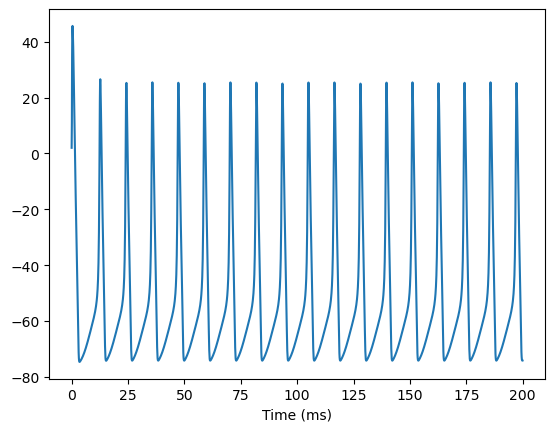

In [6]:
runner.run(200)  # the running time is 200 ms

bp.visualize.line_plot(runner.mon.ts, runner.mon.V, show=True)

A LIF neural group can be instantiated and applied in simulation in a similar way:

Compilation used 0.1110 s.
Start running ...
Run 10.0% used 0.175 s.
Run 20.0% used 0.352 s.
Run 30.0% used 0.522 s.
Run 40.0% used 0.692 s.
Run 50.0% used 0.873 s.
Run 60.0% used 1.049 s.
Run 70.0% used 1.217 s.
Run 80.0% used 1.382 s.
Run 90.0% used 1.577 s.
Run 100.0% used 1.750 s.
Simulation is done in 1.750 s.



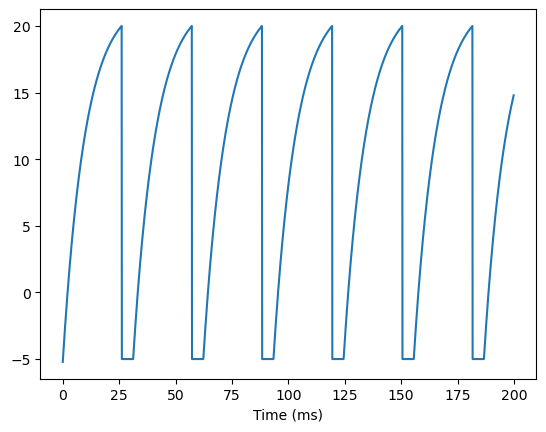

In [7]:
group = LIF(10)

runner = bp.ReportRunner(group, monitors=['V'], inputs=('input', 22.), jit=True)
runner.run(200)

bp.visualize.line_plot(runner.mon.ts, runner.mon.V, show=True)